# LBA: Grocery store prices
In this assignment, we model the cost of groceries in different parts of the world. To what extent do
grocery prices vary by country and store brand? Are grocery prices and the geographical
distribution of different grocery stores correlated with other cost-of-living measures- for example,
rent and real estate prices?

## Task 1: Prices
What is the basic average price for each product? You need to think carefully about how to
anchor the basic price for each product since this will depend on the currency used as well
as the distribution of prices.<br><br>

- Anchor in Euros
- Anchor at units that make sense for each category but is base 10 metric, e.g. milk in l, apples and potatoes in kg, meat, tomatoes, and butter in 0.1kg. 

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy.stats as stats

### Processing done before import
- changed country column to be standardized:
    - USA, UK, Germany (got rid of cities and alternative names for the countries)
    - Also change supermarket names to make sure the same market would have the same name there (e.g. 4 people went to the 4th street Trader Joe's)
- turned all rent prices into one number 
    - In 3 largest cities, looked up the price myself to be consistent in source within the city
        - San Francisco: https://www.zumper.com/blog/map-san-francisco-neighborhood-rent-prices-fall-2018/
        - Berlin: https://www.immobilienscout24.de/content/dam/is24/ibw/dokumente/mietmap_berlin_2020.jpg (this is the 2020 version of the 2016 map from the instructions)
        - London: https://maps.london.gov.uk/rents/ the official government map. I set it to 2 bedroom to approximate the Berlin one.
    - All other cities
        - took average where a range was given
        - converted to the country's currency where different unit was given
- sorted first by submitter then by country in excel
- exported to tsv to avoid commas in people's responses
- verified outliers with the authors, for example the 73GBP for bananas should be 0.73GBP
- used Mathematica to create a dictionary of conversion rates to EUR

In [2]:
# import the data
data = np.loadtxt("LBAData.tsv", delimiter="\t",dtype=object)
with open("conversions.json") as file:
    conversions = json.load(file)

In [3]:
#dimensions
print("The dimesnions of the data set:",np.shape(data))
#example datapoint
print("An example data point:",data[4])

The dimesnions of the data set: (65, 68)
An example data point: ['10/30/2020 15:38:17' 'a.bricken@minerva.kgi.edu' 'Alexander Bricken'
 'Germany' 'EUR' 'EDEKA, Str. der Pariser Kommune 38, 10243 Berlin'
 'Mid-range' '915' '1' '3.42' '1' '3.55' '1' '4.44' '1' '0.86' '1' '1.95'
 '1' '1.95' '1' '3.42' '1' '3.89' '1' '4.88' '1' '0.58' '1' '0.58' '1'
 '1.69' '1' '1.34' '1' '0.97' '1' '0.87' '1' '7.4' '1' '6.5' '1' '7.81'
 '1' '1.65' '1' '0.76' '1' '1.05' '1' '8.6' '1' '8.9' '1' '9.2' '6' '1.56'
 '6' '1.75' '6' '2.44' '1' '7.45' '1' '9.8' '1' '8.25']


In [4]:
# make a dictionary to encode all the indexes
products = ['apples','bananas','tomatoes','potatoes','flour','rice','milk','butter','eggs','chicken']
indexes = {'country': 3,
          'currency': 4,
          'brand': 6,
          'rent': 7}

for no, prod in enumerate(products):
    for i in range (3):
        indexes[prod + str(i)] = 8+6*no+i*2
print(indexes)

{'country': 3, 'currency': 4, 'brand': 6, 'rent': 7, 'apples0': 8, 'apples1': 10, 'apples2': 12, 'bananas0': 14, 'bananas1': 16, 'bananas2': 18, 'tomatoes0': 20, 'tomatoes1': 22, 'tomatoes2': 24, 'potatoes0': 26, 'potatoes1': 28, 'potatoes2': 30, 'flour0': 32, 'flour1': 34, 'flour2': 36, 'rice0': 38, 'rice1': 40, 'rice2': 42, 'milk0': 44, 'milk1': 46, 'milk2': 48, 'butter0': 50, 'butter1': 52, 'butter2': 54, 'eggs0': 56, 'eggs1': 58, 'eggs2': 60, 'chicken0': 62, 'chicken1': 64, 'chicken2': 66}


In [5]:
# show all the quantities for one product
data[:,indexes['bananas0']]

array(['Product 1 quantity (kg)', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1.36078', '1.36078', '1', '1', '1', '1', '3.5', '1', '1',
       '0.118', '0.118', '1', '1', '0.54', '1', '0.6', '0.6', '1', '1',
       '0.78', '0.9', '1', '1', '0.453592', '0.453592', '0.2', '0.12',
       '1.3608', '0.4536', '1', '0.118', '0.45', '0.45', '0.45', '1',
       '0.91', '0.118', '0.4535924', '0.453592', '1', '1', '0.5'],
      dtype=object)

In [6]:
# write a function that normalizes by target unit and converts the currency
def get_normalized_price(i, target_unit):
    # set all missing prices to 0 to filter them out later
    units = np.array([1 if x=="" else x for x in data[1:,i]], dtype=np.float)
    price = np.array([0 if x=="" else x for x in data[1:,i+1]], dtype=np.float)
    normalized_price = price/units*target_unit
    normalized_price_EUR = []
    for no, x  in enumerate(normalized_price):
        normalized_price_EUR.append( x*conversions[str(data[no+1,indexes['currency']])] )
    return normalized_price_EUR

In [41]:
apples = np.transpose([get_normalized_price(indexes['apples0'],1),
           get_normalized_price(indexes['apples1'],1),
           get_normalized_price(indexes['apples2'],1)])
bananas = np.transpose([get_normalized_price(indexes['bananas0'],1),
           get_normalized_price(indexes['bananas1'],1),
           get_normalized_price(indexes['bananas2'],1)])
# measure tomatoes in 100g
tomatoes = np.transpose([get_normalized_price(indexes['tomatoes0'],0.1),
           get_normalized_price(indexes['tomatoes1'],1),
           get_normalized_price(indexes['tomatoes2'],1)])
potatoes = np.transpose([get_normalized_price(indexes['potatoes0'],1),
           get_normalized_price(indexes['potatoes1'],1),
           get_normalized_price(indexes['potatoes2'],1)])
flour = np.transpose([get_normalized_price(indexes['flour0'],1),
           get_normalized_price(indexes['flour1'],1),
           get_normalized_price(indexes['flour2'],1)])
rice = np.transpose([get_normalized_price(indexes['rice0'],1),
           get_normalized_price(indexes['rice1'],1),
           get_normalized_price(indexes['rice2'],1)])
milk = np.transpose([get_normalized_price(indexes['milk0'],1),
           get_normalized_price(indexes['milk1'],1),
           get_normalized_price(indexes['milk2'],1)])
# measure butter in 100g
butter = np.transpose([get_normalized_price(indexes['butter0'],0.1),
           get_normalized_price(indexes['butter1'],0.1),
           get_normalized_price(indexes['butter2'],0.1)])
# get 10 eggs, the common unit in Germany (so EUR)
eggs = np.transpose([get_normalized_price(indexes['eggs0'],10),
           get_normalized_price(indexes['eggs1'],10),
           get_normalized_price(indexes['eggs2'],10)])
# measure butter in 100g
chicken = np.transpose([get_normalized_price(indexes['chicken0'],1),
           get_normalized_price(indexes['chicken1'],1),
           get_normalized_price(indexes['chicken2'],1)])

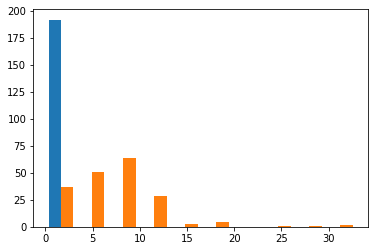

In [42]:
plt.hist([butter.flatten(),chicken.flatten()])
plt.show()

In [43]:
# also adjust the rent prices by country currency
rent = []
for no, x in enumerate(data[1:,indexes['rent']]):
    x = x.replace(',','')
    x = float(x.replace('$',''))
    new_price = x*conversions[str(data[no+1,indexes['currency']])]
    rent.append(new_price)

In [44]:
# a dictionary for the brand code and country code
# I 1-index them since stan uses 1 index
brand_code = {'Budget (cheap)': 1,'Mid-range': 2, 'Luxury (expensive)': 3}
country_code = {'Germany': 1, 'Guatemala': 2, 'Morocco': 3, 'South Korea': 4, 'UK': 5, 'USA': 6, 'Vietnam': 7}

In [45]:
# dictionary to encode the brand perception
# create a list of four lists representing the price, brand perception country, product and rent price

product_data = [apples,bananas,tomatoes,potatoes,flour,rice,milk,butter,eggs,chicken]
product = []
price = []
brand = []
country = []
rent_cost = []
for n, p in enumerate(product_data): # each product (10 total)
    for i, x in enumerate(p): # each supermarket (64 total)
        for p in x: # each price (3 total)
            if p != 0:
                # the number of the product
                product.append(n+1)
                # the price of the product
                price.append(p)
                # the brand perception of the product
                brand.append(brand_code[data[i+1,indexes['brand']]])
                # the country of the procuct
                country.append(country_code[data[i+1,indexes['country']]])
                # the cost of rent close to the supermarket
                rent_cost.append(rent[i])
reshaped_data = np.array([price,brand,country,product,rent_cost])

In [46]:
print("An example data point in our new dataset:",reshaped_data[:,4],"\n price of 2.730 euro, in a mid-range store, in Germany, for apples, where rent costs 1015 EUR.")

An example data point in our new dataset: [2.730e+00 2.000e+00 1.000e+00 1.000e+00 1.015e+03] 
 price of 2.730 euro, in a mid-range store, in Germany, for apples, where rent costs 1015 EUR.


In [47]:
# group the rent by country
rent_by_country = {}
for i, x in enumerate(rent):
    if data[i+1,indexes['country']] in rent_by_country.keys() and x != 0:
        rent_by_country[data[i+1,indexes['country']]].append(x)
    elif x != 0:
        rent_by_country[data[i+1,indexes['country']]] = [x]

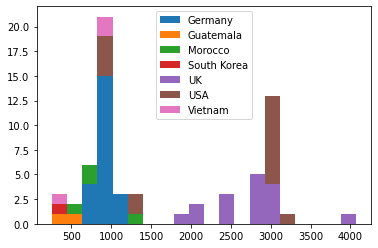

In [48]:
countries = list(rent_by_country.keys())
by_country_list = [rent_by_country[key] for key in countries]
plt.hist(by_country_list,20, histtype='bar', stacked=True, label=countries)
plt.legend(prop={'size': 10})
plt.show()

## Task 2: Factors influencing prices
How much does each of the following factors modify the basic price of the product (up or
down)?
- The geographical location (country) of the grocery store.
- Brand of the grocery store. Since we are getting data from multiple countries, you will need to specify whether the store brand is considered budget (cheap), mid-range, or luxury (expensive). This should be based on what you think the general public perception of the store brand is.
- Does price variation by geographical location correlate with variation in rental prices, or
not?

Explain in your report how strong each of these effects is. Which has the greatest influence
on price variation between shops?

Notes:
- Two levels of categorical variables
    - country
    - grocery store rating
- one numeric variable: rent price
- Determine significance and size of the variation between categories

# Model
You are encouraged to use the model structure described below for this assignment. However, you
may modify the model if you have ideas on how to improve it. If you do decide to modify the model,
you have to do so in a way that still allows you to address all points in the Questions to Answer section above. 
You should also motivate any changes to the model.<br>
Implement your model in PyStan, generate samples from the posterior, present your posterior
results, and use your posteriors to answer the questions provided.<br>
The basic idea of the model is that each type of product (apples, bananas, etc.) has a base price,
with multipliers depending on store brand and geographical location.<br>
- The base price of each product.
    - Price is a positive real number.
    - It is up to you to choose a good prior.
- The multiplier for each store type (budget/mid-range/luxury).
    - This is a scale parameter (positive real number).
    - The prior can be centered on 1, to achieve an average multiplier of 1. This would make the base price (approximately) match the average price in mid-range stores.
- The multiplier for the country or state.
    - This is a scale parameter (positive real number).
    - The prior should also be centered on 1. Expensive countries/states will have multipliers above 1 and inexpensive countries will have multipliers below 1.<br>

For example,
-  The base price of 1 liter of full cream milk might be 0.70 ¼.
-  ALDI stores are considered inexpensive and might be only 0.9 times as expensive as the average store.
- Stores in Germany might be 1.4 times more expensive than stores in the average country or state.
So as a result, 1 liter of full cream milk in an ALDI store in Berlin should cost about 0.70 * 0.9 *
1.4 = 0.88  with some random variation around that value.

In [49]:
# define the data for the stan model
stan_data = {
    'n': len(reshaped_data[0]),
    'prices': reshaped_data[0],
    # 1 for cheap, 2 for mid-range, 3 for expensive
    'n_brands' : 3,
    'brand' : reshaped_data[1].astype(int),
    # by alphabet [Germany:1, Guatemala:2, Morocco: 3, South Korea: 4, UK:5, USA:6, Vietnam:7]
    'n_countries' : 7,
    'country' : reshaped_data[2].astype(int),
    # product category 1(apple) through 10(chicken)
    'n_products' : 10,
    'product' : reshaped_data[3].astype(int),
    # rent price
    'rent' : reshaped_data[4]
}

In [50]:
# define stan code
stan_code = """
data {
    int<lower=1> n;
    real<lower=0> prices[n];
    int<lower=1> n_brands;
    int<lower=1> n_countries;
    int<lower=0> brand[n];
    int<lower=0> country[n];
    int<lower=1> n_products;
    int<lower=0> product[n];
}

parameters {
    real<lower = 0> average_price[n_products];
    real<lower = 0> sigma[n_products];
    real<lower = 0> brand_multiplier[n_brands];
    real<lower = 0> country_multiplier[n_countries];
}

model {
    brand_multiplier ~ lognormal(1,0.5);
    country_multiplier ~ lognormal(1,0.5);
    average_price ~ normal(2,1);
    for (t in 1:n){
       prices[t] ~ normal(average_price[product[t]]*brand_multiplier[brand[t]]*country_multiplier[country[t]], sigma[product[t]]);
    };
    }

"""
# define stan model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5486e1e314826e5b0b27dcf40e50b0ef NOW.


In [51]:
stan_results = stan_model.sampling(data=stan_data)
print(stan_results.stansummary(pars=['average_price','brand_multiplier','country_multiplier'], probs=[0.01, 0.5, 0.99]))

Inference for Stan model: anon_model_5486e1e314826e5b0b27dcf40e50b0ef.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd     1%    50%    99%  n_eff   Rhat
average_price[1]        1.44  9.4e-3   0.27   0.86   1.43   2.11    818   1.01
average_price[2]         0.7  4.7e-3   0.13   0.42   0.69   1.04    800   1.01
average_price[3]        1.29  8.4e-3   0.25   0.77   1.28   1.94    894   1.01
average_price[4]        0.66  4.4e-3   0.12    0.4   0.66   0.99    802   1.01
average_price[5]        0.77  6.1e-3   0.22   0.35   0.76   1.34   1259   1.01
average_price[6]        1.51  9.6e-3   0.28   0.91    1.5   2.23    872   1.01
average_price[7]        0.95  8.3e-3   0.29   0.39   0.93   1.73   1207    1.0
average_price[8]        0.35  2.3e-3   0.06   0.21   0.34   0.52    811   1.01
average_price[9]         2.7    0.01   0.72   1.12   2.67   4.51   3463    1.0
average_price[10]    

In [52]:
samples = stan_results.extract()

In [53]:
# we need to transpose the array to access one product at a time
price_array = np.transpose(np.array(samples['average_price']))
print(np.shape(price_array))
# one country at a time
country_array = np.transpose(np.array(samples['country_multiplier']))
print(np.shape(country_array))
# one store brand index at a time
brand_array = np.transpose(np.array(samples['brand_multiplier']))
print(np.shape(brand_array))

(10, 4000)
(7, 4000)
(3, 4000)


Posterior 98% confidence interval of the price for cheap : [0.64424658 1.63192625]
Posterior 98% confidence interval of the price for mid-range : [0.8194305  2.06275646]
Posterior 98% confidence interval of the price for expensive : [1.06641992 2.67164413]


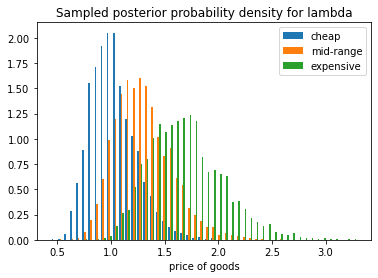

In [54]:
ratings = ['cheap','mid-range','expensive']
plt.hist([x for x in brand_array], bins=50, density=True)
plt.xlabel("price of goods")
plt.title('Sampled posterior probability density for lambda')
plt.legend(ratings)
for n in range(len(brand_array)):
    print(
        "Posterior 98% confidence interval of the price for",ratings[n],":",
        np.percentile(brand_array[n], [1, 99]))
plt.show()

Posterior 98% confidence interval of the price for apples : [0.86524888 2.11268873]
Posterior 98% confidence interval of the price for bananas : [0.41833813 1.04006885]
Posterior 98% confidence interval of the price for tomatoes : [0.76639081 1.93525399]
Posterior 98% confidence interval of the price for potatoes : [0.40277157 0.98589637]
Posterior 98% confidence interval of the price for flour : [0.34589764 1.33850786]
Posterior 98% confidence interval of the price for rice : [0.91300574 2.22685907]
Posterior 98% confidence interval of the price for milk : [0.39265779 1.73430221]
Posterior 98% confidence interval of the price for butter : [0.20725665 0.51545236]
Posterior 98% confidence interval of the price for eggs : [1.11626955 4.50697778]
Posterior 98% confidence interval of the price for chicken : [2.07984925 4.96437452]


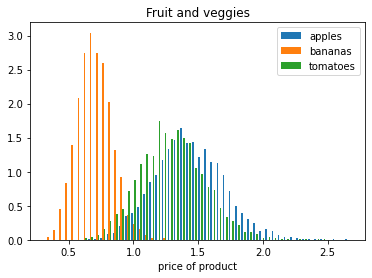

In [55]:
plt.hist([x for x in price_array[0:3]],bins=50,density=True)
plt.xlabel("price of product")
plt.title('Fruit and veggies')
plt.legend(products)
for n in range(10):
    print(
        "Posterior 98% confidence interval of the price for",products[n],":",
        np.percentile(price_array[n], [1, 99]))
plt.show()

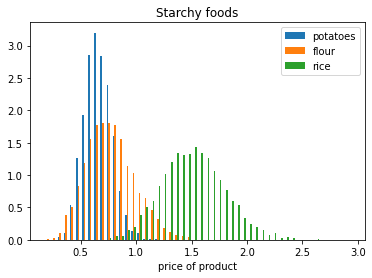

In [56]:
plt.hist([x for x in price_array[3:6]],bins=50,density=True)
plt.xlabel("price of product")
plt.title('Starchy foods')
plt.legend(products[3:6])
plt.show()

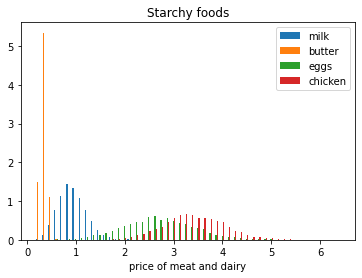

In [57]:
plt.hist([x for x in price_array[6:10]],bins=50,density=True)
plt.xlabel("price of meat and dairy")
plt.title('Starchy foods')
plt.legend(products[6:10])
plt.show()